# Workbook

This notebook contains all the necessary code (reading data, preprocessing, padding, masking, etc.) from [dataset_and_models.ipynb](dataset_and_models.ipynb) to get started on building and training the neural networks for the excercises in [labday.md](labday.md). The utility functions are now imported from python modules. It is advised to also put your model definitions in a module once finalized.

As mentioned there, make sure to:
* define your Model(s) with configurable hyperparameters as functions or classes.
* be able to save/load your model and all states necessary to evaluate this later on an independent test data set.

It also makes sense to copy this notebook (or copy the code into script/modules) for building different models (e.g. the Deep Set NN from task 2 and the GCN from task 3).

# Reading, Converting and Mapping

In [1]:
# autoreload changed modules (see https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html for caveats)
%load_ext autoreload
%autoreload all

In [2]:
import json
from pathlib import Path

import awkward as ak
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split

from utils import (
    load_data,
    get_adj,
    preprocess,
    GraphDataset,
    collate_fn,
    fit,
)

In [3]:
feature_columns = ["prodTime", "x", "y", "z", "energy", "px", "py", "pz"]

In [4]:
df, labels = load_data("smartbkg_dataset_4k.parquet", row_groups=[0])

In [5]:
with open("pdg_mapping.json") as f:
    pdg_mapping = dict(json.load(f))

In [6]:
data = preprocess(df, pdg_mapping=pdg_mapping, feature_columns=feature_columns)

# Adjacency Matrix and GCN

For GCN models we also need the adjacency matrices (for others it can be ignored)

In [7]:
data["adj"] = [get_adj(index, mother) for index, mother in zip(data["index"], data["mother"])]

# Build a model
Example models from the introductory notebook are provided in `models.py`. Adjust them to your needs

In [8]:
from models import from_config

It's good practice to make your model setups reproducible from a single configuration which you can store to reproduce your model later, e.g:

In [9]:
save_path = Path("saved_models")
save_path.mkdir(exist_ok=True)
tag = "deepset_combined_wgcn" # name identifying the setup (used to name the folder to save model and configuration to)
model_path = save_path / tag
model_path.mkdir(exist_ok=True)

In [10]:
config = {
    "model_name": "deepset_combined_wgcn",
    "units": 32,
}

In [11]:
with open(model_path / f"config.json", "w") as f:
    json.dump(config, f)

In [12]:
model = from_config(config) # build model from config

In [13]:
model

CombinedModel_wGCN(
  (embedding_layer): Embedding(185, 8)
  (gcn_layer): GCN(
    (linear): Linear(in_features=16, out_features=32, bias=True)
  )
  (deep_set_layer): DeepSetLayer(
    (per_item_mlp): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
    )
    (global_mlp): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
    )
  )
  (output_layer): OutputLayer(
    (output_layer): Sequential(
      (0): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)

# Fit Model
This section features the generator for the gcn models that provides `features`, `pdg_mapped` and `adj` - you can also use it for models that don't use all inputs, if you define the `forward` function to take a batch as a dictionary, ignoring the unused keys.

In [14]:
data_train = {}
data_val = {}
(
    data_train["features"], data_val["features"],
    data_train["pdg_mapped"], data_val["pdg_mapped"],
    data_train["adj"], data_val["adj"],
    y_train, y_val
) = train_test_split(data["features"], data["pdg_mapped"], data["adj"], labels)

In [15]:
dl_train, dl_val = [
    torch.utils.data.DataLoader(
        GraphDataset(feat=x["features"], pdg=x["pdg_mapped"], adj=x["adj"], y=y),
        batch_size=256,
        collate_fn=collate_fn
    )
    for x, y in [(data_train, y_train), (data_val, y_val)]
]

In [16]:
history = []

In [17]:
history = fit(model, dl_train, dl_val, epochs=10, history=history)

Epoch 0
Batch 292/293, Train loss: 0.649, Train accuracy: 0.614, Validation loss: 0.597, Validation accuracy: 0.677
Epoch 1
Batch 292/293, Train loss: 0.576, Train accuracy: 0.698, Validation loss: 0.549, Validation accuracy: 0.719
Epoch 2
Batch 292/293, Train loss: 0.547, Train accuracy: 0.723, Validation loss: 0.531, Validation accuracy: 0.734
Epoch 3
Batch 292/293, Train loss: 0.532, Train accuracy: 0.736, Validation loss: 0.518, Validation accuracy: 0.744
Epoch 4
Batch 292/293, Train loss: 0.521, Train accuracy: 0.744, Validation loss: 0.508, Validation accuracy: 0.752
Epoch 5
Batch 292/293, Train loss: 0.514, Train accuracy: 0.749, Validation loss: 0.502, Validation accuracy: 0.755
Epoch 6
Batch 292/293, Train loss: 0.508, Train accuracy: 0.753, Validation loss: 0.496, Validation accuracy: 0.759
Epoch 7
Batch 292/293, Train loss: 0.504, Train accuracy: 0.756, Validation loss: 0.492, Validation accuracy: 0.762
Epoch 8
Batch 292/293, Train loss: 0.500, Train accuracy: 0.758, Validat

In [18]:
pd.DataFrame(history)

,loss,val_loss,acc,val_acc
0,0.648701,0.597229,0.613956,0.677360
1,0.575861,0.549041,0.697791,0.719264
2,0.546991,0.530733,0.723194,0.734493
3,0.531939,0.517911,0.736300,0.744122
4,0.521213,0.508342,0.744034,0.751898
5,0.513766,0.501538,0.749474,0.755466
6,0.508161,0.496211,0.753167,0.758915
7,0.503546,0.492043,0.756194,0.761607
8,0.499689,0.488549,0.758313,0.763600
9,0.496384,0.485587,0.760620,0.765754


<Axes: >

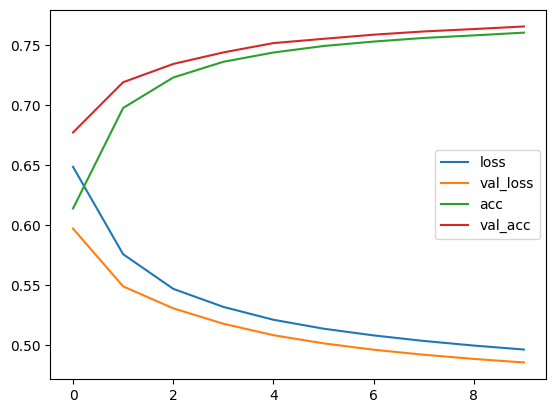

In [19]:
df_history = pd.DataFrame(history)
df_history.plot()

In [20]:
df_history.to_csv(model_path / "history.csv")

After training you should then save your model weights

In [21]:
torch.save(model.state_dict(), model_path / "state.pt")